In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

## Applying DRNN to IMDB data

### data loading and preprocessing

In [3]:
from keras.datasets import imdb
from matplotlib import pyplot

Using TensorFlow backend.


In [4]:
INDEX_FROM = 3
VOCAB_DIM = 50

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(index_from = INDEX_FROM)

In [6]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [7]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [8]:
# Summarize number of classes
print("Classes: ")
print(np.unique(y))

Classes: 
[0 1]


In [9]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Number of words: 
88585


Review length: 
Mean 234.76 words (172.911495)


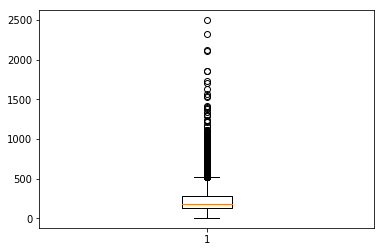

In [10]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [11]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

In [12]:
id_to_word = {v: k for k, v in word_to_id.items()}

In [13]:
glove_input_file = '/mnt/data2/xinsongdu/projects/w2v_resources/wiki_50.txt'

In [14]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [15]:
wv_embedding = loadGloveModel(glove_input_file)

Loading Glove Model
Done. 400000  words loaded!


In [16]:
wv_embedding['<UNK>'] = np.zeros(VOCAB_DIM)
wv_embedding['<PAD>'] = np.zeros(VOCAB_DIM)

In [17]:
wv_embedding['hello']

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

In [18]:
X_corpus = []
for sent in X:
    X_corpus.append(' '.join([id_to_word[i] for i in sent]))

In [19]:
max_len = max([len(sent.split()) for sent in X_corpus])

In [20]:
seq_len = 50

In [21]:
def embedding_transformation(word2vec):
    from collections import defaultdict
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    idx2vec = []
    
    for i, tok in enumerate(list(word2vec.keys())):
        tok2idx[tok] = i
        idx2tok.append(tok)
        idx2vec.append(word2vec[tok])
    return tok2idx, idx2tok, idx2vec

In [22]:
token2idx, idx2token, idx2vector = embedding_transformation(wv_embedding)

In [23]:
idx2vector = np.array(idx2vector)
idx2vector.shape

(400002, 50)

In [24]:
def prepare_tokenized_sents(corpus, max_len):
    data_x = []
    for i, sent in enumerate(corpus):
        data_x.append([])
        tokenized_sent = tknzr.tokenize(sent)
        pad_len = max_len - len(tokenized_sent)
#        print(pad_len)
        for j in range(max_len):
            if j < pad_len:
                data_x[i].append(token2idx['<PAD>'])
            else:
#                for k in sent.split():
                if tokenized_sent[j-max_len] in wv_embedding:
                    data_x[i].append(token2idx[tokenized_sent[j-max_len]])
                else:
                    data_x[i].append(token2idx['<UNK>'])
    return data_x

In [25]:
data_x = prepare_tokenized_sents(X_corpus, seq_len)

In [26]:
data_y = y

## function of disconnecting input

In [27]:
max_len

2494

In [28]:
def disconnect_input(input_idx, window_size):
    adjusted_input = []
    n_windows = seq_len - window_size + 1
    for i in range(len(input_idx)):
        adjusted_input.append([])
        for j in range(n_windows):
            adjusted_input[i].append(input_idx[i][j:(j + window_size)])
    return n_windows, adjusted_input

In [29]:
n_windows, adjusted_data_x = disconnect_input(data_x, 15)

In [30]:
#selected_data_x = adjusted_data_x[5000:8000]

In [31]:
#selected_data_y = data_y[5000:8000]

In [32]:
#len(selected_data_x)

In [33]:
#len(selected_data_y)

In [34]:
def batch_generator(batch_size, batch_index, input_x, input_y):
    input_x = np.array(input_x)
    input_y = np.array(input_y)
    if (batch_index+1)*batch_size < len(input_x):
        return input_x[batch_index*batch_size: (batch_index+1)*batch_size], input_y[batch_index*batch_size: (batch_index+1)*batch_size]
    else:
        select = random.sample(range(batch_index * batch_size), (batch_index+1)*batch_size - len(input_x))
        return np.concatenate([input_x[batch_index*batch_size: len(input_x)], input_x[select]]), np.concatenate([input_y[batch_index*batch_size: len(input_y)], input_y[select]]) 

## Split Train Validation and Test

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train_x, test_x, train_y, test_y = train_test_split(adjusted_data_x, data_y, test_size=0.2, random_state=None, stratify = data_y, shuffle = True)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=None, stratify = train_y, shuffle = True)

In [37]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

In [38]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(32000, 36, 15)
(32000,)
(8000, 36, 15)
(8000,)
(10000, 36, 15)
(10000,)


## Build Neural Network

In [39]:
class DRNN():
    pass

In [40]:
def declare_placeholders(self):
    self.input_batch = tf.placeholder(dtype=tf.int32, shape=[None, None, None], name='input_batch')
    self.ground_truth_labels = tf.placeholder(dtype=tf.int32, shape=[None, None], name='ground_truth_labels')
    
#    self.lengths = tf.placeholder(dtype=tf.int32, shape=[None], name='lengths')
    self.dropout_ph = tf.placeholder_with_default(tf.cast(0.5, tf.float32), shape=[])
    
    self.learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

In [41]:
DRNN.__declare_placeholders = classmethod(declare_placeholders)

In [42]:
def build_layers(self, vocabulary_size, n_hidden_rnn, window_size):
    
#    window_size = 15
    
    n_windows = seq_len - window_size + 1
    
    initial_embedding_matrix = idx2vector    
    with tf.name_scope("embedding"):
        embedding_matrix_variable = tf.Variable(initial_embedding_matrix, dtype = tf.float32, name = 'embedding_matrix_variable', trainable = False)
#        self.embeddings = tf.nn.embedding_lookup(params = embedding_matrix_variable, ids = self.input_batch)
    
    self.unpooled_outputs = []
    for i in range(n_windows): 
#        print(i)
        with tf.name_scope("gru_block_%s"%i):
            embeddings = tf.nn.embedding_lookup(params = embedding_matrix_variable, ids = self.input_batch[:, i], 
                                                     name = 'embedding_output')
            gru_cell = tf.nn.rnn_cell.DropoutWrapper(cell = tf.nn.rnn_cell.GRUCell(num_units = n_hidden_rnn), 
                                                         input_keep_prob = self.dropout_ph,
                                                         output_keep_prob = self.dropout_ph,
                                                         state_keep_prob = self.dropout_ph)
            self.rnn_output, _ = tf.nn.dynamic_rnn(cell = gru_cell,
                                                   dtype = tf.float32,
                                                   inputs = embeddings,
                                                   scope = "rnn_%s"%i)

            self.extracted_rnn_output = tf.layers.batch_normalization(self.rnn_output[:,-1], axis = -1)
            self.unpooled_outputs.append(tf.layers.dense(self.extracted_rnn_output, 64, activation=None))

    self.pooled_outputs = tf.layers.max_pooling1d(inputs = tf.transpose(self.unpooled_outputs, [1, 0, 2]),
                                                  pool_size = n_windows,
                                                  strides = 1,
                                                  padding = 'valid')

    self.logits = tf.layers.dense(self.pooled_outputs, 2, activation=None)

In [43]:
DRNN.__build_layers = classmethod(build_layers)

In [44]:
def compute_predictions(self):
    softmax_output = tf.nn.softmax(logits = self.logits)
    self.predictions = tf.argmax(input = softmax_output, axis = -1)

In [45]:
DRNN.__compute_predictions = classmethod(compute_predictions)

In [46]:
def compute_loss(self):
    ground_truth_labels_one_hot = tf.one_hot(self.ground_truth_labels, 2)
    self.loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels = ground_truth_labels_one_hot, logits = self.logits)
    self.loss = tf.reduce_mean(self.loss_tensor)

In [47]:
DRNN.__compute_loss = classmethod(compute_loss)

In [48]:
def perform_optimization(self):
    self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate_ph)
    self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
    clip_norm = tf.cast(1.0, tf.float32)
    self.grads_and_vars = [(tf.clip_by_norm(grad, clip_norm), var) for grad, var in self.grads_and_vars]
    self.train_op = self.optimizer.apply_gradients(self.grads_and_vars)

In [49]:
DRNN.__perform_optimization = classmethod(perform_optimization)

In [50]:
def init_model(self, vocabulary_size, n_hidden_rnn, window_size):
    self.__declare_placeholders()
    self.__build_layers(vocabulary_size, n_hidden_rnn, window_size)
    self.__compute_predictions()
    self.__compute_loss()
    self.__perform_optimization()

In [51]:
DRNN.__init__ = classmethod(init_model)

## Train network and do prediction

In [52]:
def train_on_batch(self, session, x_batch, y_batch, learning_rate, dropout_keep_probability):
    feed_dict = {self.input_batch: x_batch,
                 self.ground_truth_labels: y_batch,
                 self.learning_rate_ph: learning_rate,
                 self.dropout_ph: dropout_keep_probability}
    
    session.run(self.train_op, feed_dict=feed_dict)

In [53]:
DRNN.train_on_batch = classmethod(train_on_batch)

In [54]:
def predict_for_batch(self, session, x_batch):
    
    feed_dict = {self.input_batch: x_batch}
    predictions = session.run(self.predictions, feed_dict = feed_dict)
    return predictions

In [55]:
DRNN.predict_for_batch = classmethod(predict_for_batch)

In [56]:
from sklearn.metrics import precision_recall_fscore_support as prf

In [57]:
tf.reset_default_graph()
model = DRNN(vocabulary_size = len(token2idx),
                   n_hidden_rnn = 64, window_size = 15)

In [58]:
import math
batch_size = 16
n_epochs = 32
learning_rate = 0.001
learning_rate_decay = 1.2
dropout_keep_probability = 0.7
#lengths = max_len
n_batches = math.ceil(len(train_x)//batch_size)

In [59]:
def evaluation(model, session, data, label):#, lengths):
    from sklearn.metrics import precision_recall_fscore_support as prf
    from sklearn.metrics import roc_auc_score, accuracy_score
    y_pred = model.predict_for_batch(sess, data)#, lengths)
    y_true = label
    precision, recall, f_score, _ = prf(y_true = y_true, y_pred = y_pred, average = 'macro')
    auroc = roc_auc_score(y_true = y_true, y_score = y_pred, average = 'macro')
    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    print('precision: ', precision, 'recall: ', recall, 'f-score: ', f_score, 'AUROC: ', auroc, 'accuracy: ', acc)
#    return nn_test

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Start training... \n')
for epoch in range(n_epochs):
    # For each epoch evaluate the model on train and validation data
    print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(n_epochs) + '-' * 20)
    print('Train data evaluation:')
    evaluation(model, sess, train_x, train_y)
    print('Validation data evaluation:')
    evaluation(model, sess, val_x, val_y)
    
    # Train the model
    for batch_index in range(n_batches):
#        print(".",end="")
        if (batch_index*100/n_batches)%10 == 0:
            print(batch_index/n_batches)
        dt = batch_generator(batch_size, batch_index, train_x, train_y)
        feed_dict = {model.input_batch: dt[0],
                 model.ground_truth_labels: dt[1].reshape(batch_size,1),
                 model.learning_rate_ph: learning_rate,
                 model.dropout_ph: dropout_keep_probability}
        model.train_on_batch(sess, dt[0], dt[1].reshape(batch_size, 1), learning_rate, dropout_keep_probability)
    
print('...training finished.')

Start training... 

-------------------- Epoch 1 of 32 --------------------
Train data evaluation:
precision:  0.5087681855156749 recall:  0.501375 f-score:  0.3681926955259185 AUROC:  0.501375 accuracy:  0.501375
Validation data evaluation:
precision:  0.5103624010639795 recall:  0.501625 f-score:  0.3685094703088085 AUROC:  0.501625 accuracy:  0.501625
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
-------------------- Epoch 2 of 32 --------------------
Train data evaluation:
precision:  0.5468847371296512 recall:  0.54471875 f-score:  0.539399024186253 AUROC:  0.54471875 accuracy:  0.54471875
Validation data evaluation:
precision:  0.545051026214955 recall:  0.5427500000000001 f-score:  0.5368358570587837 AUROC:  0.5427500000000001 accuracy:  0.54275
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
-------------------- Epoch 3 of 32 --------------------
Train data evaluation:
precision:  0.5761263750326491 recall:  0.576125 f-score:  0.57612308593081 AUROC:  0.5761249999999999 accuracy:  0.576125
V